<a href="https://www.kaggle.com/code/daiman971/p8-gan-032023?scriptVersionId=122950457" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Table of content

1. Introduction to GAN
2. Competiton context
3. Data preparation
4. Model preparation
    - 4.1. Different type of Neural Networks
    - 4.2. Evaluation of time generation
    - 4.3. Build the GAN
5. Train the GAN
6. Test the GAN
7. Create submission file

# 1. Introduction to GAN

# 2. Competition context

The main purpose of this competition is to make a GAN that will be able to generate between 7000 and 10000 images with the style of the famous painter Monet.

The generated images have to be jpg format with a size of 256x256x3 (RGB) and be zipped in a single file named images.zip.  
The evaluation metric used by kaggle to know if the image is considered good is MiFD: **Memorization-informed Fréchet Inception Distance**.  
The smaller MiFID is, the better your generated images are.  
More details can be found at: [Kaggle Competition](https://www.kaggle.com/competitions/gan-getting-started/overview/description).  

# 3. Data Preparation

Based on "Monet CycleGAN Tutorial" notebook from Amy Jang, wich is a tutorial starter for this competition, we will prepare the setup and data we need to implement our GAN. It can be found there:  
[https://www.kaggle.com/amyjang/monet-cyclegan-tutorial](https://www.kaggle.com/amyjang/monet-cyclegan-tutorial)
  
This notebook gives basis of how data will be loaded inside a kaggle notebook. The method used in this notebbok to generate images is called cycleGAN, that we won't use for the time being.

First of all, we have decided to try executing"Monet CycleGAN Tutorial" notebook to know how it works and how long it takes to train and generate images for the competiton.  
The notebook take around 1h to execute. It trains a CycleGAN on 25 epochs with 300 images with each epoch taking around 40s (except for the first one).  
That notebook generate a bit more than 7000 images that saved on a images.zip file.  
That notebook used a TPU to be run.  
An explanation about TPU and ow it's used on kaggle can be found here: [Kaggle TPU documentation](https://www.kaggle.com/docs/tpu).  
In order to evaluate how TPU is usefull for the executaion, we tried to run the notebook without using TPU.  
After running withou TPU, the same noteboo took around 11h to be executed. We could notice that each training epoch took around 1600s compared to 40s with TPU.  
Based on that, we choose to use TPU as the same way it's used in Amy Jang notebook.  
First, we need to activate the use of TPU (v3-8) on our kaggle notebook like this:  
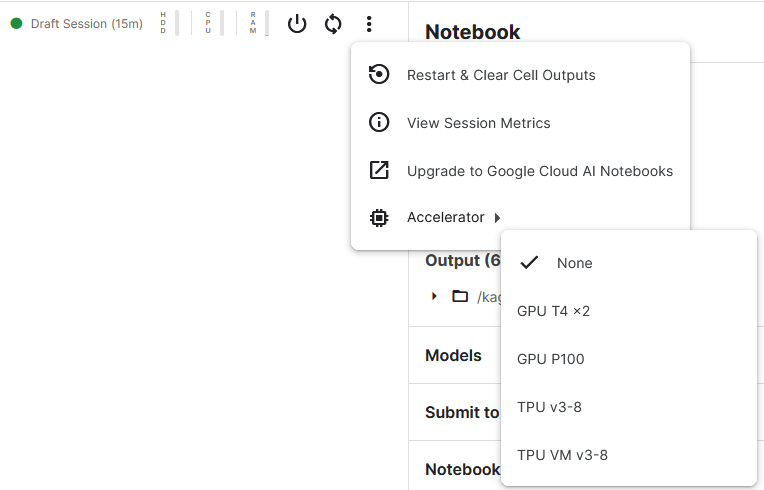

In [2]:
# Library for Data science

import tensorflow as tf #NN processing
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
import time

from IPython import display

In [4]:
# Library for TPU acceleration
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.11.0


## Loading Data

The dataset we are using contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg.  
The monet_tfrec and monet_jpg directories contain the same painting images sized 256x256 in JPEG format or TFRecord format, and the photo_tfrec and photo_jpg directories contain the same photos also sized 256x256 in JPEG format or TFRecord format.  

The monet directories contain Monet paintings that we will use for training our models.  
The photo directories contain photos that we will add Monet-style and submit the new generated images.  

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [5]:
GCS_PATH = KaggleDatasets().get_gcs_path() #Get path of data from competition dataset

In [6]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [7]:
img_sz = 256
IMAGE_SIZE = [img_sz, img_sz]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.



In [8]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [9]:
batch_size = 12

In [10]:
# batch_size: number of consecutive elements of this dataset to combine in a single batch --> batch_size=1 will give 1 element in each batch where we have a number of batch=number of elements in the dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(batch_size)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(batch_size)

We tool one exemple of each of theses lists.

In [11]:
#next : Get following element of the iter(list) each time it is called. 
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Let's visualize a photo example and a Monet example.

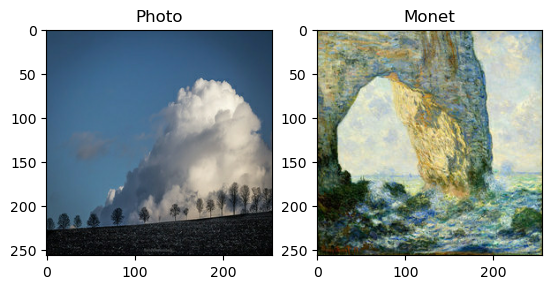

In [12]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

Exception ignored in: <function Executor.__del__ at 0x7f5f6d554830>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


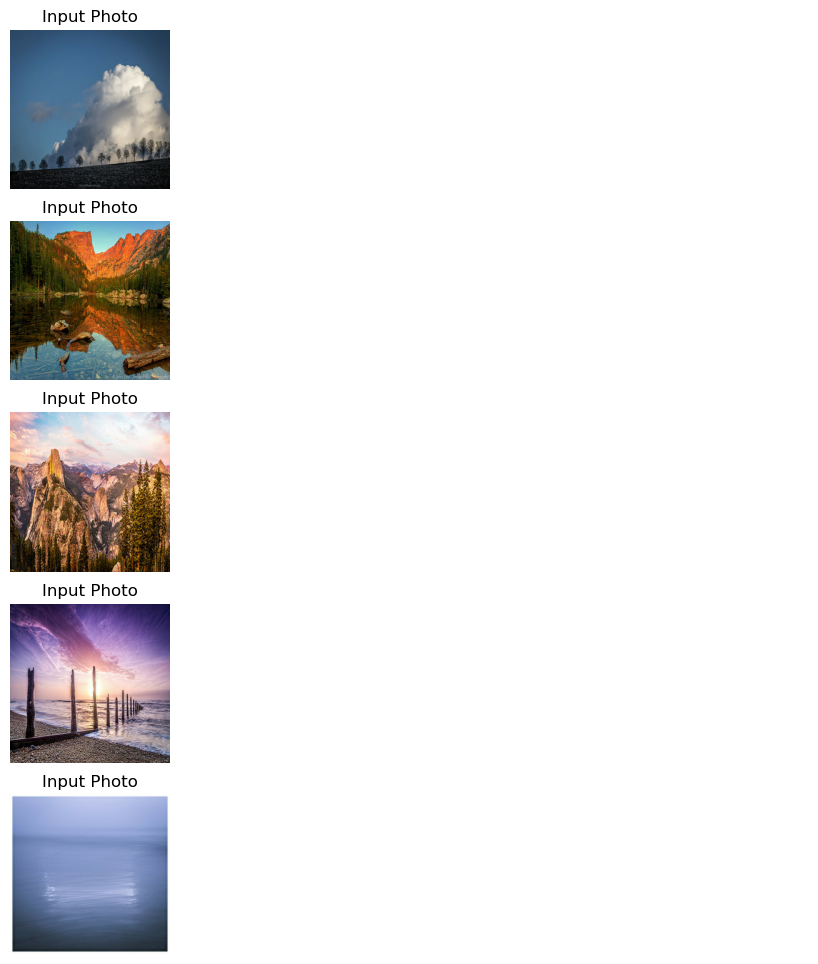

In [13]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    #print(str(i))
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    #ax[i, 1].imshow(monet)
    ax[i, 0].set_title("Input Photo")
    #ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()


Calcul of number of elements in datasets.

In [14]:
len_monet_ds = 0
for i in monet_ds:
    #print(i)
    #print(len(i))
    len_monet_ds = len_monet_ds + len(i)
    #len_monet_ds+=1

Exception ignored in: <function Executor.__del__ at 0x7f5f6d554830>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [15]:
len_monet_ds #len_data = 

300

In [16]:
len_photo_ds = 0
for i in photo_ds:
    #print(i)
    #len_photo_ds+=1
    len_photo_ds = len_photo_ds + len(i)
len_photo_ds

Exception ignored in: <function Executor.__del__ at 0x7f5f6d554830>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


7038

In [17]:
# monet_ds.cardinality().numpy()
#INFINITE_CARDINALITY	-1
#UNKNOWN_CARDINALITY	-2

# 4. Model preparation

In order to build our GAN, we use the cGAN tutorial from TensorFlow helping us to prepare all the functions we need: https://www.tensorflow.org/tutorials/generative/dcgan?hl=en  

## 4.1. Different type of Neural Networks

- CNN-based scratch model with better tools for GAN
- CNN based on U-Net model

In this project, we will make only two types of CNN models: scratch model and a pix2pix based scratch model.

The CNN-based scratch model is based on https://www.geeksforgeeks.org/building-a-generative-adversarial-network-using-keras/ made in 2019/06.  
It uses functions and methods which are not really fitted anymore for GAN use (Upsampling2D, relu, ...).  
The second one will use methods from pix2pix CNN based on https://www.tensorflow.org/tutorials/generative/pix2pix?hl=en#build_the_generator Tensofflow tutorial in 2022/08. It usually uses a simplified U-Net architecture.

In [18]:
input_shape = tuple(IMAGE_SIZE) + (3,) #[256,256,3]
input_shape

(256, 256, 3)

### 4.1.1. Generator design

In [19]:
def basic_generator():  
    
        #inputs = keras.Input(shape=input_shape)
        model = tf.keras.Sequential()
  
        #Building the input layer
        model.add(keras.Input(shape=(100,)))
    
        model.add(layers.Dense(128 * 32 * 32, activation="relu"))
        model.add(layers.Reshape((32, 32, 128)))
        
        #print(model.output_shape)  
        model.add(layers.UpSampling2D())
        #print(model.output_shape)
        
        model.add(layers.Conv2D(256, kernel_size=3, padding="same"))
        model.add(layers.BatchNormalization(momentum=0.78))
        model.add(layers.LeakyReLU())
          
        model.add(layers.UpSampling2D())
          
        model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
        model.add(layers.BatchNormalization(momentum=0.78))
        model.add(layers.LeakyReLU())
        
        #print(model.output_shape)
        model.add(layers.UpSampling2D())
        
        #print(model.output_shape)
        
        model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
        model.add(layers.BatchNormalization(momentum=0.78))
        model.add(layers.LeakyReLU())
        
        #print(model.output_shape)
          
        model.add(layers.Conv2D(3, kernel_size=3, padding="same"))
        model.add(layers.Activation("relu"))
        
        #assert model.output_shape == (None, 28, 28, 1) # we need to be sure our NN will generate an image with the same input_shape as we'll use it as the discriminator input also
        #model.add(layers.Dense(3, activation="relu"))
        """
        last_input = model.output_shape
        print("last_input: " + str(last_input))
        
        k_size = last_input[1] - img_sz*np.sign(last_input[1] - img_sz+1) + 1 # 1: strides of kernel filters
        
        print("k_size: "+str(k_size))
        print(str(np.sign(last_input[1] - img_sz)))
        model.add(layers.Conv2D(3, kernel_size=(k_size,k_size), padding="valid"))
        model.add(layers.Activation("tanh"))
        """
        #print(model.output_shape)
        assert model.output_shape == (None, img_sz, img_sz, 3) # we need to be sure our NN will generate an image with the same input_shape as we'll use it as the discriminator input also
        

        #Generating the output image
        #noise = Input(shape=(latent_dimensions,))
        #image = model(noise)
  
        #return Model(noise, image)
        return model

## Define generator based on https://www.tensorflow.org/tutorials/generative/pix2pix?hl=en#build_the_generator

In [20]:
OUTPUT_CHANNELS = 3

In [21]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                         kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [22]:
inp = example_photo[0] * 0.5 + 0.5

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [23]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [24]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [25]:
def pix_generator():
    
    #inputs = keras.Input(shape=input_shape)

    #Building the input layer
     
    #inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    inputs = tf.keras.layers.Input(shape=(100,))
    
    x = inputs
    x = layers.Dense(256 * 256 * 3, activation="relu") (x)
    x = layers.Reshape((256, 256, 3))(x)

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                     strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     activation='tanh')  # (batch_size, 256, 256, 3)

    #x = inputs
    """
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    """
    
    # Downsampling through the model
    for down in down_stack:
        x = down(x)

    # Upsampling and establishing the skip connections
    for up in up_stack:
        x = up(x)

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 131072)            13238272  
                                                                 
 reshape (Reshape)           (None, 32, 32, 128)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 batch_normalization_2 (Batc  (None, 64, 64, 256)      1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 256)      

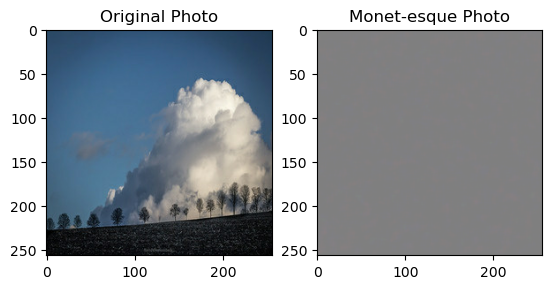

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 196608)            19857408  
                                                                 
 reshape_1 (Reshape)         (None, 256, 256, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 128, 128, 64)      3072      
                                                                 
 sequential_4 (Sequential)   (None, 64, 64, 128)       131584    
                                                                 
 sequential_5 (Sequential)   (None, 32, 32, 256)       525312    
                                                                 
 sequential_6 (Sequential)   (None, 16, 16, 512)       209920

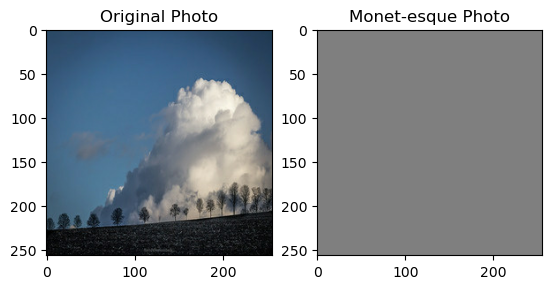

In [26]:
# Exemple of generated images from a photo input passed through ou basic generator
noise_input = tf.random.normal([1, 100])

for test_generator in [basic_generator(),pix_generator()]:
    test_generator.summary()

    start = time.time()
    to_monet = test_generator(noise_input)
    print ('Time for one generated_image from photo is {} sec'.format(time.time()-start))

    plt.subplot(1, 2, 1)
    plt.title("Original Photo")
    plt.imshow(example_photo[0] * 0.5 + 0.5)

    plt.subplot(1, 2, 2)
    plt.title("Monet-esque Photo")
    plt.imshow(to_monet[0] * 0.5 + 0.5)
    plt.show()

We need to generate at least 7000 images in less than 5h (and 3h if we use TPU).  
Let see the average calculation for 100 images generated for each methods.

In [27]:
# Exemple of generated images from a photo input passed through our basic generator

gen_time =[[],[],[]]
for num_ex in  range(100):
    
    noise_input = tf.random.normal([1, 100])
    i=0
    for test_generator in [basic_generator(),pix_generator()]:
        #test_generator.summary()

        start = time.time()
        to_monet = test_generator(noise_input)
        #print ('Time for one generated_image from photo is {} sec'.format(time.time()-start))
        
        time_gen = time.time()-start
        gen_time[i].append(time_gen)
        i+=1


In [28]:
len(gen_time)

3

In [29]:
len(gen_time[0])

100

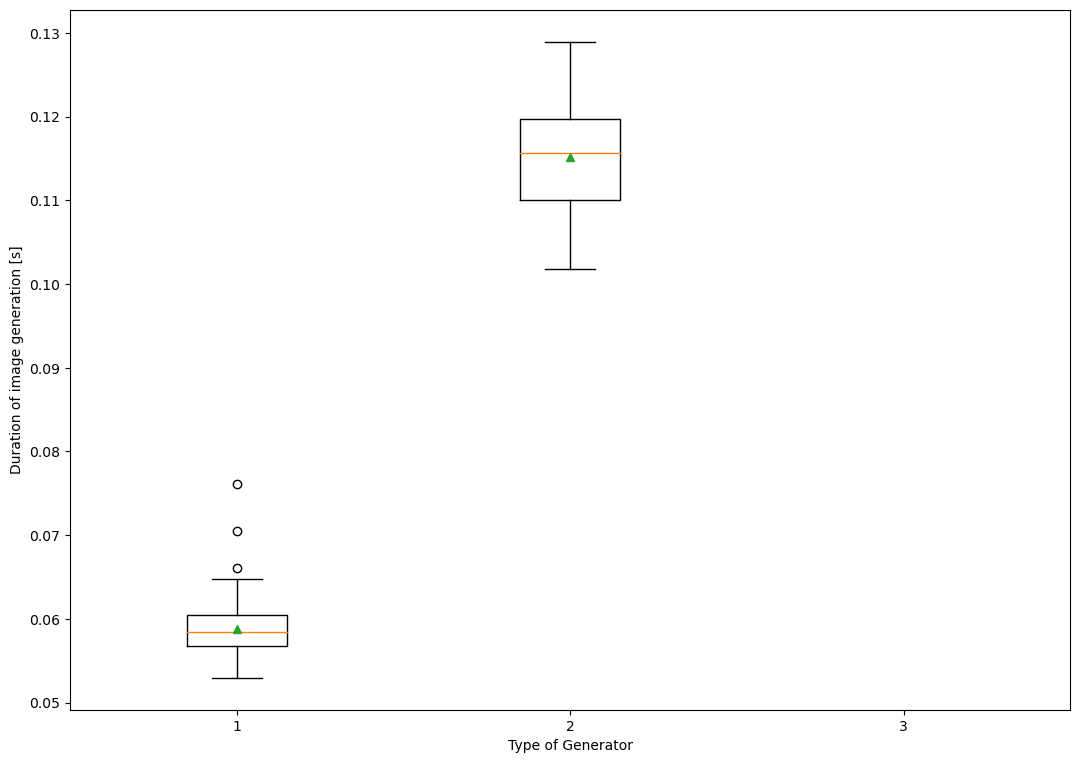

In [30]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(gen_time, showmeans=True)
plt.xlabel("Type of Generator")
plt.ylabel("Duration of image generation [s]")
#plt.legend(['Duration','Mean'])
#ax.legend([bp['boxes'][0],bp['boxes'][1],bp['boxes'][2]],['A','B','C'])
# show plot
plt.show()

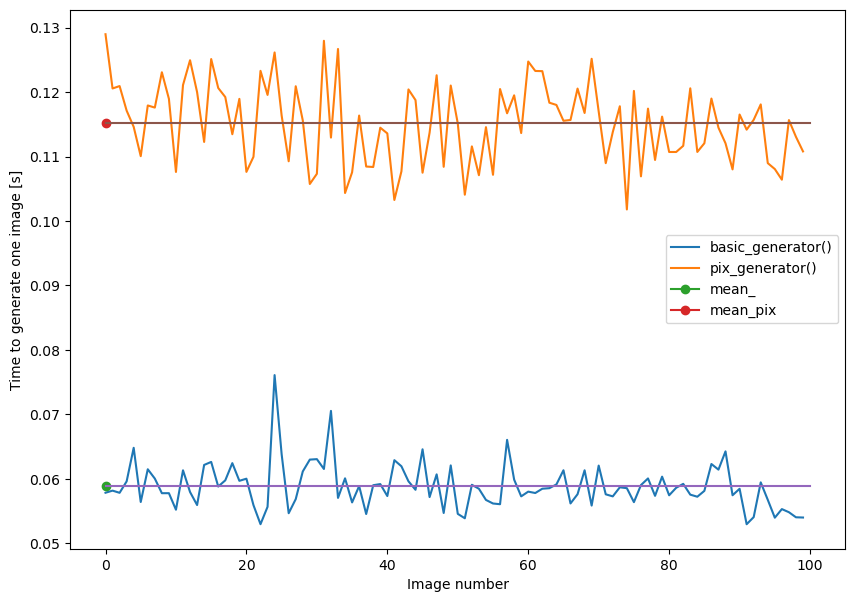

In [31]:
fig = plt.figure(figsize =(10, 7))
plt.plot(gen_time[0])
plt.plot(gen_time[1])

plt.plot(np.mean(gen_time[0]),marker='o')
plt.plot(np.mean(gen_time[1]),marker='o')

plt.plot([0,100],[np.mean(gen_time[0]),np.mean(gen_time[0])])
plt.plot([0,100],[np.mean(gen_time[1]),np.mean(gen_time[1])])

plt.legend(['basic_generator()','pix_generator()',
           'mean_','mean_pix'])

plt.xlabel("Image number")
plt.ylabel("Time to generate one image [s]")

plt.show()

In [32]:
# We choose the following geenrator:
with strategy.scope():
    test_generator = pix_generator()
test_generator.summary()

Model: "model_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_203 (InputLayer)      [(None, 100)]             0         
                                                                 
 dense_202 (Dense)           (None, 196608)            19857408  
                                                                 
 reshape_202 (Reshape)       (None, 256, 256, 3)       0         
                                                                 
 sequential_1618 (Sequential  (None, 128, 128, 64)     3072      
 )                                                               
                                                                 
 sequential_1619 (Sequential  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 sequential_1620 (Sequential  (None, 32, 32, 256)      52

Time for one generated_image from photo is 0.32084155082702637 sec


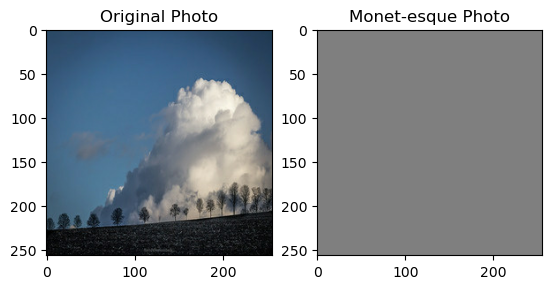

In [33]:
# Exemple of generated images from a photo input passed through ou basic generator
noise_input = tf.random.normal([1, 100])

start = time.time()
to_monet = test_generator(noise_input)
print ('Time for one generated_image from photo is {} sec'.format(time.time()-start))

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

 
1h = 3600s --> 3600s/0.25s = 14400 images could be generated in one hour.  
We need to generate at least 7000 images in less than 5h (3h if we use TPU).  
This method seems computationnaly valuable. Let's test it.  

The second method using a U-Net-like architecture seems faster to generate images.  
It's maybe because of the upsamplings, downsamplings, skips and dropout steps that seems using less computer ressources.  
We need to generate 7000 images in less than 5h (or 3h using TPU).

In [34]:
input_shape

(256, 256, 3)

In [35]:
example_photo.shape

TensorShape([12, 256, 256, 3])

In [36]:
example_photo[0].shape

TensorShape([256, 256, 3])

In [37]:
noise_input.shape

TensorShape([1, 100])

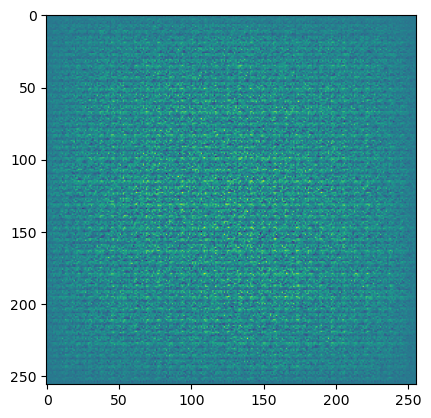

In [38]:
# Image generated from a random image
noise = tf.random.normal([1, 100])
generated_image = test_generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

Time for one generated_image from noise is 0.3216886520385742 sec


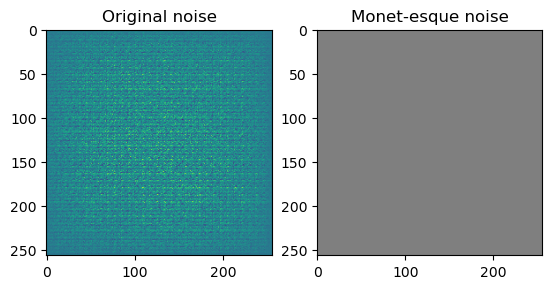

In [39]:
# Exemple of generated images from a photo input passed through ou basic generator
start = time.time()
noise_to_monet = test_generator(noise)
print ('Time for one generated_image from noise is {} sec'.format(time.time()-start))

plt.subplot(1, 2, 1)
plt.title("Original noise")
plt.imshow(generated_image[0, :, :, 0])

plt.subplot(1, 2, 2)
plt.title("Monet-esque noise")
plt.imshow(noise_to_monet[0] * 0.5 + 0.5)
plt.show()

### 4.1.2. Discriminator design

In [40]:
def basic_discriminator():
    #Building the convolutional layers
    #to classify whether an image is real or fake
    
    #inputs = tf.keras.Input(shape=input_shape)
    model = tf.keras.Sequential()
  
    #Building the input layer
    model.add(keras.Input(shape=input_shape))
    
    #model = Sequential()

    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.82))
    model.add(layers.LeakyReLU(alpha=0.25))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.82))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.25))
    model.add(layers.Dropout(0.25))
    
    #print(model.output_shape)

    #Building the output layer
    model.add(layers.Flatten())
    print(model.output_shape)
    #assert model.output_shape == (None, 278784)
    model.add(layers.Dense(1, activation='sigmoid'))

    #image = Input(shape=image_shape)
    #validity = model(image)

    #return Model(image, validity)
    return model

In [41]:
def pix_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    #inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    #tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    #x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    x = inputs

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
    
    last2 = tf.keras.layers.Flatten()(last)
    last3 = tf.keras.layers.Dense(1)(last2)

    return tf.keras.Model(inputs=inputs, outputs=last3)

In [42]:
generated_image.shape

TensorShape([1, 256, 256, 3])

In [43]:
generated_image[0].shape

TensorShape([256, 256, 3])

In [44]:
with strategy.scope():
    test_discriminator = pix_discriminator()
test_discriminator.summary()

Model: "model_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_204 (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1633 (Sequential  (None, 128, 128, 64)     3072      
 )                                                               
                                                                 
 sequential_1634 (Sequential  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 sequential_1635 (Sequential  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 34, 34, 256)      0         
 2D)                                                     

In [45]:
decision = test_discriminator(example_photo)
print (decision)

tf.Tensor(
[[ 0.04399414]
 [-0.03600469]
 [ 0.00921194]
 [ 0.07365438]
 [ 0.06140979]
 [-0.00902466]
 [-0.01789244]
 [-0.02171437]
 [ 0.03365559]
 [-0.00014843]
 [-0.00124993]
 [-0.01414089]], shape=(12, 1), dtype=float32)


In [46]:
decision = test_discriminator(generated_image)
print (decision)

tf.Tensor([[1.5532013e-09]], shape=(1, 1), dtype=float32)


In [47]:
input_shape

(256, 256, 3)

In [48]:
example_photo.shape

TensorShape([12, 256, 256, 3])

## 4.3. Buid the GAN

### 4.3.1. Define the loss and optimizers

In [49]:
with strategy.scope():
    # This method returns a helper function to compute cross entropy loss
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
    
    
    # we need to use reduction=tf.keras.losses.Reduction.NONE because of the use of strategy.scope()
    
    
    """
    ValueError: Please use `tf.keras.losses.Reduction.SUM` or `tf.keras.losses.Reduction.NONE` for loss reduction when losses are used with `tf.distribute.Strategy` outside of the built-in training loops. You can implement `tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE` using global batch size like:
    ```
    with strategy.scope():
        loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    ....
        loss = tf.reduce_sum(loss_obj(labels, predictions)) * (1. / global_batch_size)
    ```
    Please see https://www.tensorflow.org/tutorials/distribute/custom_training for more details.
    """

# UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
#  '"`binary_crossentropy` received `from_logits=True`, but the `output`'
# --> If the discriminator end with sigmoid or softmax, the output will be between 0 to 1, or from_logits=True expect value from -inf to inf. If from_logits=False, values expected are from 0 to 1. That's why we could see an error.

In [50]:
with strategy.scope():
    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

In [51]:
with strategy.scope():
    def generator_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

In [52]:
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [53]:
#checkpoint_dir = './training_checkpoints'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                 discriminator_optimizer=discriminator_optimizer,
#                                 generator=generator,
#                                 discriminator=discriminator)

In [54]:
generator_loss(noise_to_monet)

<tf.Tensor: shape=(1, 256, 256), dtype=float32, numpy=
array([[[0.6931472 , 0.6931472 , 0.6931472 , ..., 0.6931472 ,
         0.6931472 , 0.6931472 ],
        [0.6931471 , 0.6931472 , 0.6931472 , ..., 0.6931471 ,
         0.6931472 , 0.6931472 ],
        [0.6931472 , 0.6931471 , 0.69314724, ..., 0.6931472 ,
         0.6931472 , 0.6931472 ],
        ...,
        [0.6931472 , 0.6931472 , 0.6931471 , ..., 0.6931471 ,
         0.6931472 , 0.6931472 ],
        [0.6931472 , 0.6931472 , 0.6931472 , ..., 0.6931472 ,
         0.6931472 , 0.6931472 ],
        [0.6931472 , 0.6931472 , 0.6931472 , ..., 0.6931472 ,
         0.6931472 , 0.6931472 ]]], dtype=float32)>

In [55]:
discriminator_loss(example_photo,noise_to_monet)

<tf.Tensor: shape=(12, 256, 256), dtype=float32, numpy=
array([[[1.6424074, 1.6424074, 1.6376255, ..., 1.7132155, 1.7132155,
         1.7112206],
        [1.6424074, 1.6376255, 1.6376255, ..., 1.708221 , 1.708221 ,
         1.7081093],
        [1.6376255, 1.6376255, 1.6328578, ..., 1.7083362, 1.708221 ,
         1.7081093],
        ...,
        [1.9403548, 1.9571805, 1.9015378, ..., 2.006409 , 1.981682 ,
         2.0025904],
        [1.9741184, 1.9459509, 1.9459509, ..., 1.9760073, 2.0025904,
         2.0025904],
        [1.9180971, 1.8905624, 1.9797891, ..., 1.9199442, 2.006409 ,
         2.006409 ]],

       [[2.006409 , 2.006409 , 2.006409 , ..., 1.9760113, 2.0044997,
         1.9930726],
        [2.006409 , 2.006409 , 2.006409 , ..., 1.9873734, 2.0025945,
         2.0025945],
        [2.006409 , 2.006409 , 2.006409 , ..., 2.0044997, 1.9987841,
         1.9816861],
        ...,
        [2.006409 , 2.006409 , 2.006409 , ..., 1.99878  , 1.99878  ,
         1.99878  ],
        [2.00640

In [56]:
(generator_loss(noise_to_monet) + discriminator_loss(example_photo,noise_to_monet)) /2

<tf.Tensor: shape=(12, 256, 256), dtype=float32, numpy=
array([[[1.1677773, 1.1677773, 1.1653863, ..., 1.2031813, 1.2031813,
         1.202184 ],
        [1.1677773, 1.1653863, 1.1653863, ..., 1.2006841, 1.2006841,
         1.2006283],
        [1.1653863, 1.1653863, 1.1630025, ..., 1.2007418, 1.2006841,
         1.2006283],
        ...,
        [1.316751 , 1.3251638, 1.2973424, ..., 1.349778 , 1.3374145,
         1.3478688],
        [1.3336327, 1.3195491, 1.3195491, ..., 1.3345773, 1.3478688,
         1.3478688],
        [1.3056221, 1.2918549, 1.3364682, ..., 1.3065457, 1.349778 ,
         1.349778 ]],

       [[1.349778 , 1.349778 , 1.349778 , ..., 1.3345792, 1.3488234,
         1.3431098],
        [1.349778 , 1.349778 , 1.349778 , ..., 1.3402603, 1.3478708,
         1.3478708],
        [1.349778 , 1.349778 , 1.349778 , ..., 1.3488234, 1.3459656,
         1.3374166],
        ...,
        [1.349778 , 1.349778 , 1.349778 , ..., 1.3459636, 1.3459636,
         1.3459636],
        [1.34977

### 4.3.2. Save checkpoints

In [57]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=test_generator,
                                 discriminator=test_discriminator)

In [58]:
# Saving model

model_dir = './training_model'
gen_file = os.path.join(model_dir, "model_generator")
disc_file = os.path.join(model_dir, "model_discriminator")

### 4.3.3. Define training loop

In [59]:

noise_dim = 100
num_examples_to_generate = 5
BATCH_SIZE = batch_size # Comme définit en entrée
#img_sz = 256

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate,noise_dim ])

In [60]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        raw = int(np.around(num_examples_to_generate/5))
        col = 5
        
        plt.subplot(raw, col, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

<a href="./training_model/model_generator"> Download Gen File </a>
<a href="./training_model/model_discriminator"> Download Disc File </a>

In [61]:
class GAN_class(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN_class, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss):
        super(GAN_class, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
        
    def train_step(self, images):
        
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # add codes to save losses
        #return [gen_loss, disc_loss]
        return {
            "gen_loss": gen_loss,
            "disc_loss": disc_loss,
            "decision":fake_output
            }

    # Notice the use of `tf.function`
    # This annotation causes the function to be "compiled".
    @tf.function
    def train_step_to_distribute(self, images):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # add codes to save losses
        #return [gen_loss, disc_loss]
        return (gen_loss + disc_loss)/2
    
    @tf.function
    def distributed_train_step(self, images):
        #images,generator,discriminator = dataset_inputs
        per_replica_losses = strategy.run(self.train_step_to_distribute, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses,
                             axis=None)
    
    def train(self, dataset, epochs):
        gen_loss_list  = []
        disc_loss_list = []
        train_loss_list = []
        decision_list = []
        
        for epoch in range(epochs):
            start = time.time()

            total_loss = 0.0
            num_batches = 0
            for image_batch in dataset:
                loss = self.distributed_train_step(image_batch)
                total_loss += tf.reduce_mean(loss)
                num_batches += 1
                train_loss = total_loss / num_batches
                
            train_loss_list.append(train_loss)

                #[gen_loss, disc_loss] = train_step(image_batch,generator,discriminator)
                #gen_loss_list.append(gen_loss)
                #disc_loss_list.append(disc_loss)

            # Produce images for the GIF as you go
            display.clear_output(wait=True)
            generate_and_save_images(self.generator,
                                     epoch + 1,
                                     seed)

            # Save the model every 15 epochs
            #if (epoch + 1) % 15 == 0:
            #    checkpoint.save(file_prefix = checkpoint_prefix)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start)) # each line printed is overwritten. The last one is not visible # -> because of display.clear_output(wait=True)?


            # Evaluate the model
            #loss, acc = generator.evaluate(test_images, test_labels, verbose=2)
            #print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))


        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(self.generator,
                               epochs,
                               seed)

        # Losses saved in lists
        #return gen_loss_list, disc_loss_list
        return train_loss_list
    

## Test

In [62]:
generated_images = test_generator(noise)

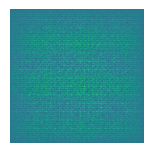

In [63]:
fig = plt.figure(figsize=(10, 10))

for i in range(generated_images.shape[0]):
    raw = int(np.around(num_examples_to_generate/5))
    col = 5

    plt.subplot(raw, col, i+1)
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5)
    plt.axis('off')

In [64]:
generated_images.shape

TensorShape([1, 256, 256, 3])

Exception ignored in: <function Executor.__del__ at 0x7f5f6d554830>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


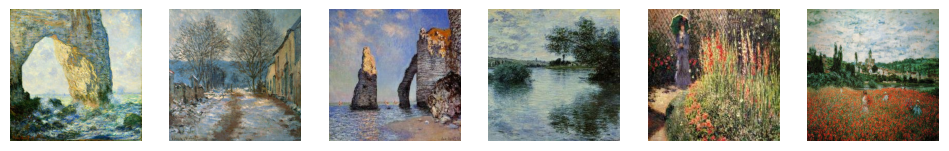

In [65]:
plt.figure(figsize=(12, 12))
i=0
nb_images = 6
for images in monet_ds.take(nb_images): #each batch taken from "take" method contains only one image
    ax = plt.subplot(nb_images, nb_images, i + 1)
    plt.imshow((images[0]* 127.5 + 127.5).numpy().astype("uint8")) #original size is between 0 to 1
    plt.axis("off")
    i+=1

In [66]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 6.2860802e-02, -6.2414837e-01, -2.5256455e-01, -4.9826241e-01,
        -8.7926221e-01,  1.5883352e+00,  5.2941966e-01,  6.0729218e-01,
         7.8876281e-01, -1.3253388e+00,  1.7235714e+00,  1.5996134e+00,
        -3.1097827e+00, -4.2051193e-01,  2.5626808e-01, -2.8760068e-02,
         8.6587298e-01,  5.3268552e-01,  1.3126945e-01, -5.5772752e-01,
         9.1799885e-01, -2.5793068e+00,  7.5426370e-01,  5.6643969e-01,
        -1.8827248e-01,  1.8056668e+00, -5.9156907e-01, -3.4145221e-01,
        -1.7334779e-01,  2.1194760e-03,  3.0480862e-01,  1.4617872e-01,
         3.6052579e-01, -8.6622703e-01, -1.9889480e+00, -7.7088803e-02,
        -4.6611342e-01, -9.5715845e-01, -1.3029099e+00,  2.3825684e+00,
        -1.9428720e+00,  1.2729560e+00,  1.3991823e+00,  1.9505166e-01,
         4.3003124e-01,  2.9634768e-01,  2.9985565e-01,  1.5661962e-01,
        -1.8263228e+00, -4.3012351e-01, -1.1656549e+00, -9.6594149e-01,
        -5.824

In [67]:
#for images in monet_ds.take(1):
#    train_step(images,test_generator,test_discriminator)


# 5. Train the GAN

In [68]:
EPOCHS = 600

# Choice of GAN strategy

iGAN = 0

# 0: monet_gan from GAN_class using distribute and train
# 1: monet_gan_bis from GAN_class using compile and fit
# 2: monet_gan_2 from GAN_class_2 using compile and fit and distribute

In [69]:
#with strategy.scope():
#[gen_loss_list, disc_loss_list] = train(monet_ds, EPOCHS,test_generator,test_discriminator)
#train_loss = train(monet_ds, EPOCHS,test_generator,test_discriminator)

In [70]:
#len(gen_loss_list)

In [71]:
#len(disc_loss_list)

In [72]:
"""
fig = plt.figure(figsize =(10, 7))
plt.plot(gen_loss_list)
plt.plot(disc_loss_list)

plt.plot(np.mean(gen_loss_list),marker='o')
plt.plot(np.mean(disc_loss_list),marker='o')

plt.plot([0,100],[np.mean(gen_loss_list),np.mean(gen_loss_list)])
plt.plot([0,100],[np.mean(disc_loss_list),np.mean(disc_loss_list)])

plt.legend(['gen_loss_list','disc_loss_list',
           'mean_gen_loss_list','mean_disc_loss_list'])

plt.xlabel("Image number")
plt.ylabel("Generator and Discriminator losses")

plt.show()
"""

'\nfig = plt.figure(figsize =(10, 7))\nplt.plot(gen_loss_list)\nplt.plot(disc_loss_list)\n\nplt.plot(np.mean(gen_loss_list),marker=\'o\')\nplt.plot(np.mean(disc_loss_list),marker=\'o\')\n\nplt.plot([0,100],[np.mean(gen_loss_list),np.mean(gen_loss_list)])\nplt.plot([0,100],[np.mean(disc_loss_list),np.mean(disc_loss_list)])\n\nplt.legend([\'gen_loss_list\',\'disc_loss_list\',\n           \'mean_gen_loss_list\',\'mean_disc_loss_list\'])\n\nplt.xlabel("Image number")\nplt.ylabel("Generator and Discriminator losses")\n\nplt.show()\n'

Restore latest checkpoint

In [73]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [74]:
if iGAN ==0:
    with strategy.scope():
        monet_gan = GAN_class(test_generator, test_discriminator)

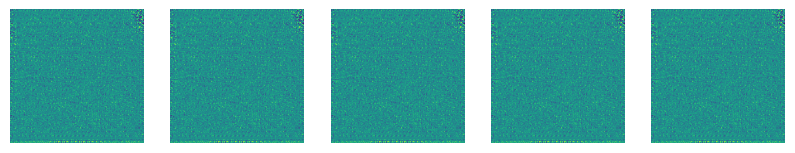

In [75]:
 #%debug
if iGAN ==0:
    train_loss_result = monet_gan.train(monet_ds, EPOCHS)

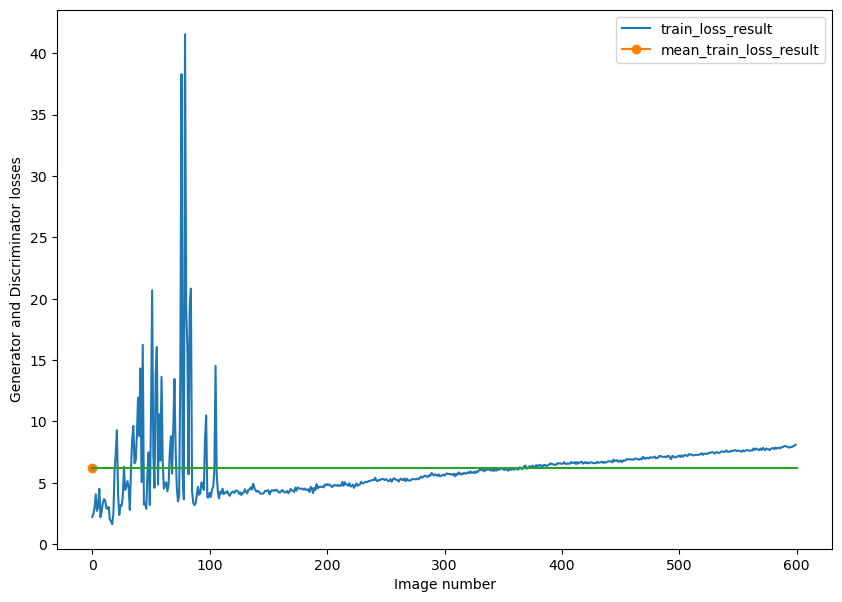

In [76]:
if iGAN ==0:
    fig = plt.figure(figsize =(10, 7))
    plt.plot(train_loss_result)

    plt.plot(np.mean(train_loss_result),marker='o')

    plt.plot([0,len(train_loss_result)],[np.mean(train_loss_result),np.mean(train_loss_result)])

    plt.legend(['train_loss_result','mean_train_loss_result'])

    plt.xlabel("Image number")
    plt.ylabel("Generator and Discriminator losses")

    plt.show()

In [77]:
if iGAN ==1:
    with strategy.scope():
        test_generator_bis = pix_generator()
        test_discriminator_bis = pix_discriminator()
        monet_gan_bis = GAN_class(test_generator_bis, test_discriminator_bis)
        monet_gan_bis.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

In [78]:
#monet_gan_bis.generator.trainable_variables

In [79]:
if iGAN ==1:
    history = monet_gan_bis.fit(monet_ds, epochs = EPOCHS)

In [80]:
if iGAN == 1:
    fig = plt.figure(figsize=(10, 10))

    #num_examples_to_generate = 10
    for i in range(monet_gan_bis.generator(noise).shape[0]):
        raw = int(np.around(num_examples_to_generate/5))
        col = 5

        plt.subplot(raw, col, i+1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

In [81]:
if iGAN ==1:
    fig = plt.figure(figsize =(10, 7))
    #plt.plot([0,len(history.history['gen_loss'])], history.history['gen_loss'])
    plt.plot(np.mean(history.history['gen_loss'], axis=1))
    plt.plot(np.mean(history.history['disc_loss'], axis=1))
    plt.plot(np.mean(history.history['decision'], axis=1))

    plt.plot(np.mean(np.mean(history.history['gen_loss'], axis=1)),marker='o')
    plt.plot(np.mean(np.mean(history.history['disc_loss'], axis=1)),marker='o')
    plt.plot(np.mean(np.mean(history.history['decision'], axis=1)),marker='o')

    plt.plot([0,len(np.mean(history.history['gen_loss'], axis=1))],[np.mean(np.mean(history.history['gen_loss'], axis=1)),np.mean(np.mean(history.history['gen_loss'], axis=1))])
    plt.plot([0,len(np.mean(history.history['disc_loss'], axis=1))],[np.mean(np.mean(history.history['disc_loss'], axis=1)),np.mean(np.mean(history.history['disc_loss'], axis=1))])
    plt.plot([0,len(np.mean(history.history['decision'], axis=1))],[np.mean(np.mean(history.history['decision'], axis=1)),np.mean(np.mean(history.history['decision'], axis=1))])


    plt.legend(['gen_loss','disc_loss','decision','mean_gen_loss','mean_disc_loss','mean_decision'])

    plt.xlabel("Image batch number")
    plt.ylabel("Generator and Discriminator losses")

    plt.show()

In [82]:
#history.history['gen_loss']

In [83]:
#np.mean(history.history['gen_loss'], axis=1)

In [84]:
#history.history['gen_loss'][0]

In [85]:
#history.history['gen_loss'][0][-1]

In [86]:
#history.history['decision']

In [87]:
#np.mean(history.history['decision'], axis=1)

In [88]:
#history.history['gen_loss'][][-1]

## New test Class

In [89]:
class GAN_class_2(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN_class_2, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss):
        super(GAN_class_2, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
    
    #@tf.function
    def train_step(self, inputs):
        def step_fn(self, images):

            noise = tf.random.normal([BATCH_SIZE, noise_dim])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = self.generator(noise, training=True)

                real_output = self.discriminator(images, training=True)
                fake_output = self.discriminator(generated_images, training=True)

                gen_loss = self.generator_loss(fake_output)
                disc_loss = self.discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

            # add codes to save losses
            #return [gen_loss, disc_loss]
            return {
                "gen_loss": gen_loss,
                "disc_loss": disc_loss
                }
        per_replica_losses = strategy.run(step_fn, args=(inputs,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses,
                             axis=None)
        
        
        """
            @tf.function
    def distributed_train_step(self, images):
        #images,generator,discriminator = dataset_inputs
        per_replica_losses = strategy.run(self.train_step_to_distribute, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses,
                             axis=None)
        """

In [90]:
if iGAN ==2:
    with strategy.scope():
        test_generator_2 = pix_generator()
        test_discriminator_2 = pix_discriminator()
        monet_gan_2 = GAN_class_2(test_generator_2, test_discriminator_2)
        monet_gan_2.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

In [91]:
if iGAN ==2:
    monet_gan_2.fit(monet_ds, epochs = EPOCHS)

In [92]:
# #Stop runing
#import sys
#sys.exit()

# 6. Test the GAN 

Création de GIF

In [93]:
if iGAN ==0:
    # Display a single image using the epoch number
    def display_image(epoch_no):
        return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

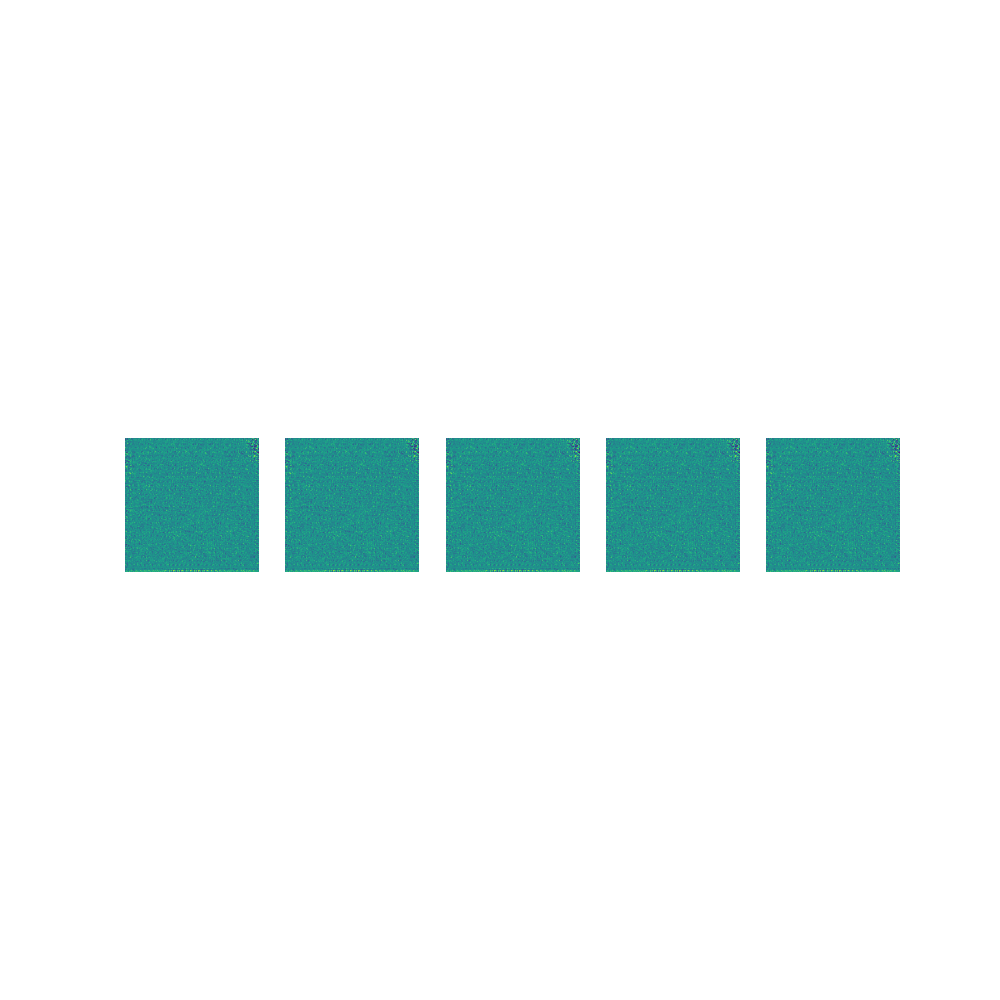

In [94]:
display_image(EPOCHS)

## Animated Gif

In [95]:
if iGAN ==0:
    import imageio.v2 as imageio

    anim_file = 'dcgan.gif'

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('image*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [96]:
if iGAN ==0:
    # To generate GIFs
    ! pip install imageio
    ! pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-zh5jzxfd
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-zh5jzxfd
  Resolved https://github.com/tensorflow/docs to commit a81ea51cef0734c602915ba3a5d4f4c755243818
  Preparing metadata (setup.py) ... - done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=186672 sha256=7e7a3cd31daba5adeae95a319fa87a111008e0a0277abc6fc2aa98d4c43da81d
  Stored in directory: /tmp/pip-ephem-wheel-cache-s6esn_32/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [97]:
if iGAN ==0:
    import tensorflow_docs.vis.embed as embed
    embed.embed_file(anim_file)

# 7. Save model

In [98]:
# Saving model

model_dir = './training_model'
gen_file = os.path.join(model_dir, "model_generator")
disc_file = os.path.join(model_dir, "model_discriminator")

In [99]:
# Methods for saving the generated folder of saved trained model in a file that we can easily download in kaggle
from zipfile import ZipFile
import os

def save_model_zip(test_folder,zip_file):

    #zip_file = "test_folder.zip"  # zip file name
    directory = test_folder

    with ZipFile(zip_file, 'w') as zip_obj:
        for path, directories, files in os.walk(directory):
            for file in files:
                file_name = os.path.join(path, file)

                zip_obj.write(file_name) # zipping the file

    print("Contents of the zip file:")
    with ZipFile(zip_file, 'r') as zip_obj:
        zip_obj.printdir()

In [100]:
# Saving actions if using CPU/GPU
"""   
monet_gan.generator.save(gen_file) # + str(epoch))
monet_gan.discriminator.save(disc_file) # + str(epoch))

zip_file = os.path.join(model_dir, "gan_model_file.zip")
#save_model_zip(gen_file,zip_file)
#save_model_zip(disc_file,zip_file) # cet enregistrement écrase le précédent
save_model_zip(model_dir,zip_file)"""

#from IPython.display import FileLink
#FileLink(gen_file)
#FileLink(disc_file)

'   \nmonet_gan.generator.save(gen_file) # + str(epoch))\nmonet_gan.discriminator.save(disc_file) # + str(epoch))\n\nzip_file = os.path.join(model_dir, "gan_model_file.zip")\n#save_model_zip(gen_file,zip_file)\n#save_model_zip(disc_file,zip_file) # cet enregistrement écrase le précédent\nsave_model_zip(model_dir,zip_file)'

In [101]:
# Saving actions if using TPU

save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

if iGAN ==0:
    monet_gan.generator.save(gen_file, options=save_locally) # + str(epoch))
    monet_gan.discriminator.save(disc_file, options=save_locally) 
elif iGAN ==1:
    monet_gan_bis.generator.save(gen_file, options=save_locally) # + str(epoch))
    monet_gan_bis.discriminator.save(disc_file, options=save_locally) 
elif iGAN ==2:
    monet_gan_2.generator.save(gen_file, options=save_locally) # + str(epoch))
    monet_gan_2.discriminator.save(disc_file, options=save_locally)     
    
zip_file = os.path.join(model_dir, "gan_model_file.zip")
#save_model_zip(gen_file,zip_file)
#save_model_zip(disc_file,zip_file) # cet enregistrement écrase le précédent
save_model_zip(model_dir,zip_file)

Contents of the zip file:
File Name                                             Modified             Size
training_model/gan_model_file.zip              2023-03-22 00:55:40            0
training_model/model_discriminator/fingerprint.pb 2023-03-22 00:55:40           55
training_model/model_discriminator/saved_model.pb 2023-03-22 00:55:40       323344
training_model/model_discriminator/keras_metadata.pb 2023-03-22 00:55:40        48977
training_model/model_discriminator/variables/variables.index 2023-03-22 00:55:40         1369
training_model/model_discriminator/variables/variables.data-00000-of-00001 2023-03-22 00:55:40     11087921
training_model/model_generator/fingerprint.pb  2023-03-22 00:55:36           53
training_model/model_generator/saved_model.pb  2023-03-22 00:55:36      1414588
training_model/model_generator/keras_metadata.pb 2023-03-22 00:55:38       180741
training_model/model_generator/variables/variables.index 2023-03-22 00:55:36         4463
training_model/model_generat

# 8. Create submission file

In [102]:
! mkdir ../images

In [103]:
i = 1
nb_img2gen = 7000
for img in range(nb_img2gen):
    noise = tf.random.normal([1, 100])
    
    if iGAN ==0:
        prediction = monet_gan.generator(noise, training=False)[0].numpy()
    elif iGAN ==1:
        prediction = monet_gan_bis.generator(noise, training=False)[0].numpy()
    elif iGAN ==2:
        prediction = monet_gan_2.generator(noise, training=False)[0].numpy()
    
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [104]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'